## 第一步
爬取半个月的天气数据，（1-7，8-14天）
小时，温度，风力方向，风级，降水量，相对湿度，空气质量
保存为csv文件

In [57]:
# weather.py
import requests
from bs4 import BeautifulSoup
import csv
import json
def getHTMLtext(url):     
	"""请求获得网页内容"""
	try:         
		r = requests.get(url, timeout = 30)         
		r.raise_for_status()         
		r.encoding = r.apparent_encoding         
		print("成功访问")         
		return r.text     
	except:         
		print("访问错误")         
		return" " 

def get_content(html):
	"""处理得到有用信息保存数据文件"""
	final = []  							 # 初始化一个列表保存数据
	bs = BeautifulSoup(html, "html.parser")  # 创建BeautifulSoup对象
	body = bs.body
	data = body.find('div', {'id': '7d'})    # 找到div标签且id = 7d
	# 下面爬取当天的数据
	data2 = body.find_all('div',{'class':'left-div'})
	text = data2[2].find('script').string	 
	text = text[text.index('=')+1 :-2]		 # 移除改var data=将其变为json数据
	jd = json.loads(text)
	dayone = jd['od']['od2']				 # 找到当天的数据
	final_day = []						     # 存放当天的数据
	count = 0
	for i in dayone:
		temp = []
		if count <=23:
			temp.append(i['od21'])				 # 添加时间
			temp.append(i['od22'])				 # 添加当前时刻温度
			temp.append(i['od24'])				 # 添加当前时刻风力方向
			temp.append(i['od25'])				 # 添加当前时刻风级
			temp.append(i['od26'])				 # 添加当前时刻降水量
			temp.append(i['od27'])				 # 添加当前时刻相对湿度
			temp.append(i['od28'])				 # 添加当前时刻控制质量
			#print(temp)
			final_day.append(temp)
		count = count +1
	# 下面爬取7天的数据	
	ul = data.find('ul')					 # 找到所有的ul标签
	li = ul.find_all('li')					 # 找到左右的li标签
	i = 0  			# 控制爬取的天数
	for day in li:  						 	# 遍历找到的每一个li
	    if i < 7 and i > 0:
	        temp = []  						 	# 临时存放每天的数据
	        date = day.find('h1').string  	 	# 得到日期
	        date = date[0:date.index('日')]  	# 取出日期号
	        temp.append(date)				        
	        inf = day.find_all('p')  		 	# 找出li下面的p标签,提取第一个p标签的值，即天气
	        temp.append(inf[0].string)

	        tem_low = inf[1].find('i').string  	# 找到最低气温

	        if inf[1].find('span') is None:  	# 天气预报可能没有最高气温
	            tem_high = None
	        else:
	            tem_high = inf[1].find('span').string  # 找到最高气温
	        temp.append(tem_low[:-1])
	        if tem_high[-1] == '℃':
	        	temp.append(tem_high[:-1])
	        else:
	        	temp.append(tem_high)

	        wind = inf[2].find_all('span')		# 找到风向
	        for j in wind:
	        	temp.append(j['title'])

	        wind_scale = inf[2].find('i').string # 找到风级
	        index1 = wind_scale.index('级')
	       	temp.append(int(wind_scale[index1-1:index1]))
	        final.append(temp)
	    i = i + 1
	return final_day,final
	#print(final)    
def get_content2(html):
	"""处理得到有用信息保存数据文件"""
	final = []  							 						# 初始化一个列表保存数据
	bs = BeautifulSoup(html, "html.parser")  						# 创建BeautifulSoup对象
	body = bs.body
	data = body.find('div', {'id': '15d'})    						# 找到div标签且id = 15d
	ul = data.find('ul')					 						# 找到所有的ul标签
	li = ul.find_all('li')					 						# 找到左右的li标签
	final = []
	i = 0  															# 控制爬取的天数
	for day in li:  						 						# 遍历找到的每一个li
	    if i < 8:
	        temp = []  						 						# 临时存放每天的数据
	        date = day.find('span',{'class':'time'}).string  		# 得到日期
	        date = date[date.index('（')+1:-2]  						# 取出日期号
	        temp.append(date)		
	       	weather = day.find('span',{'class':'wea'}).string  		# 找到天气
	        temp.append(weather)
	        tem = day.find('span',{'class':'tem'}).text		  		# 找到温度
	        temp.append(tem[tem.index('/')+1:-1])					# 找到最低气温
	        temp.append(tem[:tem.index('/')-1]) 					# 找到最高气温
	        wind = day.find('span',{'class':'wind'}).string  		# 找到风向
	        if '转' in wind:											# 如果有风向变化
	        	temp.append(wind[:wind.index('转')])
	        	temp.append(wind[wind.index('转')+1:])
	        else:													# 如果没有风向变化，前后风向一致
	        	temp.append(wind)
	        	temp.append(wind)
	        wind_scale = day.find('span',{'class':'wind1'}).string  		# 找到风级
	        index1 = wind_scale.index('级')
	       	temp.append(int(wind_scale[index1-1:index1]))
	        	
	        final.append(temp)
	return final

def write_to_csv(file_name, data, day=14):
	"""保存为csv文件"""
	with open(file_name, 'w', errors='ignore', newline='') as f:
		if day == 14:
			header = ['日期','天气','最低气温','最高气温','风向1','风向2','风级']
		else:
			header = ['小时','温度','风力方向','风级','降水量','相对湿度','空气质量']
		f_csv = csv.writer(f)
		f_csv.writerow(header)
		f_csv.writerows(data)

def main():
	"""主函数"""
	print("Weather test")
	# 广州
	url1 = 'http://www.weather.com.cn/weather/101280701.shtml'    # 7天天气中国天气网
	url2 = 'http://www.weather.com.cn/weather15d/101280701.shtml' # 8-15天天气中国天气网
	
	html1 = getHTMLtext(url1)
	data1, data1_7 = get_content(html1)		# 获得1-7天和当天的数据

	html2 = getHTMLtext(url2)
	data8_14 = get_content2(html2)			# 获得8-14天数据
	data14 = data1_7 + data8_14
	#print(data)
	write_to_csv('weather14.csv',data14,14)	# 保存为csv文件
	write_to_csv('weather1.csv',data1,1)

if __name__ == '__main__':
	main()



Weather test
成功访问
成功访问


In [58]:
data14=pd.read_csv('weather14.csv')
data14.head()
data14

,日期,天气,最低气温,最高气温,风向1,风向2,风级
0,17,多云,21,26,无持续风向,东风,3
1,18,多云,23,27,无持续风向,东风,3
2,19,多云,22,27,无持续风向,无持续风向,3
3,20,多云转阵雨,24,27,无持续风向,无持续风向,3
4,21,阵雨,25,28,无持续风向,无持续风向,3
5,22,阵雨,24,28,无持续风向,无持续风向,3
6,23,阵雨转雨,24,27,东风,东风,4
7,24,阴,24,27,东风,东北风,4
8,25,阴转多云,24,27,东风,东北风,4
9,26,阴,24,28,东风,东风,4


In [59]:
data1=pd.read_csv('weather1.csv')
data1.head()

,小时,温度,风力方向,风级,降水量,相对湿度,空气质量
0,5,19,东北风,1,0.0,77,NaN
1,4,19,东北风,2,0.0,77,17.0
2,3,19,东北风,2,0.0,78,17.0
3,2,19,东北风,2,0.0,79,16.0
4,1,19,东北风,2,0.0,77,16.0


In [60]:
x=list(data1['温度'])
print("温度有"+str(len(x))+"项")
for i in x:
  if i=='温度':
    continue
  print(i)

温度有24项
19
19
19
19
19
19
20
20
20
20
19
19
20
19
19
19
19
18
18
18
18
18
18
18


In [61]:
data1.info

<bound method DataFrame.info of     小时  温度 风力方向  风级  降水量  相对湿度  空气质量
0    5  19  东北风   1  0.0    77   NaN
1    4  19  东北风   2  0.0    77  17.0
2    3  19  东北风   2  0.0    78  17.0
3    2  19  东北风   2  0.0    79  16.0
4    1  19  东北风   2  0.0    77  16.0
5    0  19  东北风   2  0.0    78  16.0
6   23  20  东北风   2  0.0    78  15.0
7   22  20  东北风   2  0.0    79  15.0
8   21  20  东北风   2  0.0    77  16.0
9   20  20  东北风   2  0.0    80  17.0
10  19  19  东北风   1  0.0    81  19.0
11  18  19  东北风   2  0.0    82  20.0
12  17  20   北风   1  0.0    81  22.0
13  16  19  东北风   2  0.0    83  24.0
14  15  19  东北风   2  0.0    85  25.0
15  14  19  东北风   1  0.0    89  25.0
16  13  19  东北风   2  0.4    92  22.0
17  12  18   北风   1  3.2    92  20.0
18  11  18  东北风   2  0.0    90  19.0
19  10  18  东北风   2  0.0    90  19.0
20   9  18   北风   2  0.1    89  19.0
21   8  18  东北风   2  0.5    92  19.0
22   7  18  东北风   1  0.0    91  19.0
23   6  18  东北风   2  0.0    90  18.0>

In [62]:
data14.info

<bound method DataFrame.info of     日期     天气  最低气温  最高气温    风向1    风向2  风级
0   17     多云    21    26  无持续风向     东风   3
1   18     多云    23    27  无持续风向     东风   3
2   19     多云    22    27  无持续风向  无持续风向   3
3   20  多云转阵雨    24    27  无持续风向  无持续风向   3
4   21     阵雨    25    28  无持续风向  无持续风向   3
5   22     阵雨    24    28  无持续风向  无持续风向   3
6   23   阵雨转雨    24    27     东风     东风   4
7   24      阴    24    27     东风    东北风   4
8   25   阴转多云    24    27     东风    东北风   4
9   26      阴    24    28     东风     东风   4
10  27      阴    24    29    东北风     南风   3
11  28   多云转晴    24    29     南风    西南风   3
12  29   多云转晴    24    28     南风    西南风   3
13  30    阴转雨    23    28     南风     南风   3>

## 第二步
信息可视化绘制

In [67]:
from matplotlib.font_manager import FontProperties
# /simhei.ttf
font = FontProperties(fname=r"/SimHei.ttf", size=15)

    小时  温度 风力方向  风级  降水量  相对湿度  空气质量
0    5  19  东北风   1  0.0    77   NaN
1    4  19  东北风   2  0.0    77  17.0
2    3  19  东北风   2  0.0    78  17.0
3    2  19  东北风   2  0.0    79  16.0
4    1  19  东北风   2  0.0    77  16.0
5    0  19  东北风   2  0.0    78  16.0
6   23  20  东北风   2  0.0    78  15.0
7   22  20  东北风   2  0.0    79  15.0
8   21  20  东北风   2  0.0    77  16.0
9   20  20  东北风   2  0.0    80  17.0
10  19  19  东北风   1  0.0    81  19.0
11  18  19  东北风   2  0.0    82  20.0
12  17  20   北风   1  0.0    81  22.0
13  16  19  东北风   2  0.0    83  24.0
14  15  19  东北风   2  0.0    85  25.0
15  14  19  东北风   1  0.0    89  25.0
16  13  19  东北风   2  0.4    92  22.0
17  12  18   北风   1  3.2    92  20.0
18  11  18  东北风   2  0.0    90  19.0
19  10  18  东北风   2  0.0    90  19.0
20   9  18   北风   2  0.1    89  19.0
21   8  18  东北风   2  0.5    92  19.0
22   7  18  东北风   1  0.0    91  19.0
23   6  18  东北风   2  0.0    90  18.0


/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 19968 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 22825 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 28201 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 24230 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 21464 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 21270 missing from current font.
  font.set_

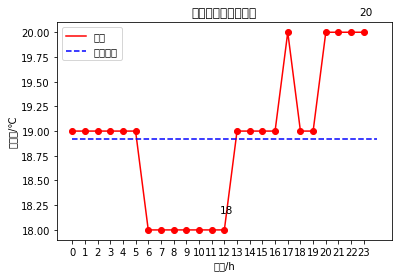

/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 30456 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 23545 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 28287 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 30334 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 20998 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 27604 missing from current font.
  font.set_

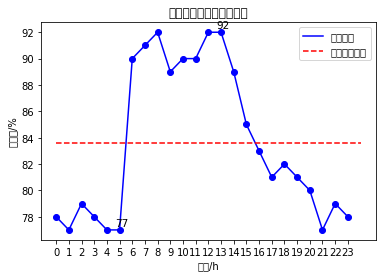

/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 31354 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 27668 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 36136 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 37327 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 25351 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 25968 missing from current font.
  font.set_

<class 'float'>


/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:183: RuntimeWarning: Glyph 31354 missing from current font.
  font.set_text(s, 0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:183: RuntimeWarning: Glyph 27668 missing from current font.
  font.set_text(s, 0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:183: RuntimeWarning: Glyph 36136 missing from current font.
  font.set_text(s, 0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:183: RuntimeWarning: Glyph 37327 missing from current font.
  font.set_text(s, 0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:183: RuntimeWarning: Glyph 25351 missing from current font.
  font.set_text(s, 0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:183: RuntimeWarning: Glyph 25968 missing from current font.
  font.set_text(s, 0,

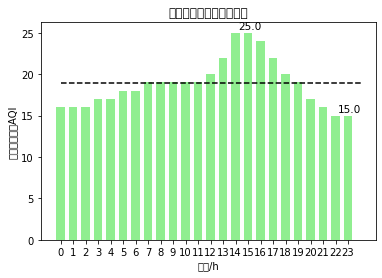

[1.8095238095238095, 1.3333333333333333, 0, 0, 0, 0, 0, 0]


/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 39118 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 32423 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:183: RuntimeWarning: Glyph 39118 missing from current font.
  font.set_text(s, 0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:183: RuntimeWarning: Glyph 32423 missing from current font.
  font.set_text(s, 0, flags=flags)


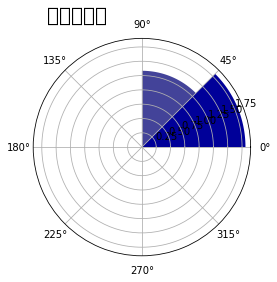

/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 20851 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 24615 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 26512 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 31995 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 20026 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 65306 missing from current font.
  font.set_

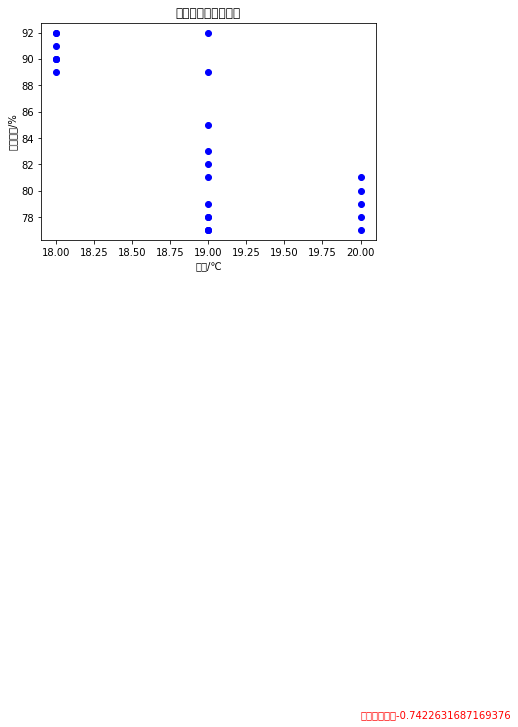

相关系数为：-0.7422631687169376


In [68]:
# data1_analysis.py
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import math
def tem_curve(data):
	"""温度曲线绘制"""
	hour = list(data['小时'])
	tem = list(data['温度'])
	for i in range(0,24):
   
		if math.isnan(tem[i]) == True:
			tem[i] = tem[i-1]
	tem_ave = sum(tem)/24					# 求平均温度 
	tem_max = max(tem)				
	tem_max_hour = hour[tem.index(tem_max)]	# 求最高温度
	tem_min = min(tem)
	tem_min_hour = hour[tem.index(tem_min)]	# 求最低温度
	x = []
	y = []
	for i in range(0, 24):
		x.append(i)
		y.append(tem[hour.index(i)])
	plt.figure(1)
	plt.plot(x,y,color='red',label='温度')							# 画出温度曲线
	plt.scatter(x,y,color='red')			# 点出每个时刻的温度点
	plt.plot([0, 24], [tem_ave, tem_ave], c='blue', linestyle='--',label='平均温度') 	# 画出平均温度虚线
	plt.text(tem_max_hour+0.15, tem_max+0.15, str(tem_max), ha='center', va='bottom', fontsize=10.5)  # 标出最高温度
	plt.text(tem_min_hour+0.15, tem_min+0.15, str(tem_min), ha='center', va='bottom', fontsize=10.5)  # 标出最低温度
	plt.xticks(x)
	plt.legend()
	plt.title('一天温度变化曲线图')
	plt.xlabel('时间/h')
	plt.ylabel('摄氏度/℃')
	plt.show()

def hum_curve(data):
	"""相对湿度曲线绘制"""
	hour = list(data['小时'])
	hum = list(data['相对湿度'])
	for i in range(0,24):
		if math.isnan(hum[i]) == True:
			hum[i] = hum[i-1]
	hum_ave = sum(hum)/24					# 求平均相对湿度 
	hum_max = max(hum)				
	hum_max_hour = hour[hum.index(hum_max)]	# 求最高相对湿度
	hum_min = min(hum)
	hum_min_hour = hour[hum.index(hum_min)]	# 求最低相对湿度
	x = []
	y = []
	for i in range(0, 24):
		x.append(i)
		y.append(hum[hour.index(i)])
	plt.figure(2)
	plt.plot(x,y,color='blue',label='相对湿度')							# 画出相对湿度曲线
	plt.scatter(x,y,color='blue')			# 点出每个时刻的相对湿度
	plt.plot([0, 24], [hum_ave, hum_ave], c='red', linestyle='--',label='平均相对湿度') 	# 画出平均相对湿度虚线
	plt.text(hum_max_hour+0.15, hum_max+0.15, str(hum_max), ha='center', va='bottom', fontsize=10.5)  # 标出最高相对湿度
	plt.text(hum_min_hour+0.15, hum_min+0.15, str(hum_min), ha='center', va='bottom', fontsize=10.5)  # 标出最低相对湿度
	plt.xticks(x)
	plt.legend()
	plt.title('一天相对湿度变化曲线图')
	plt.xlabel('时间/h')
	plt.ylabel('百分比/%')
	plt.show()

def air_curve(data):
	"""空气质量曲线绘制"""
	hour = list(data['小时'])
	air = list(data['空气质量'])
	print(type(air[0]))
	for i in range(0,24):
		if math.isnan(air[i]) == True:
			air[i] = air[i-1]
	air_ave = sum(air)/24					# 求平均空气质量 
	air_max = max(air)				
	air_max_hour = hour[air.index(air_max)]	# 求最高空气质量
	air_min = min(air)
	air_min_hour = hour[air.index(air_min)]	# 求最低空气质量
	x = []
	y = []
	for i in range(0, 24):
		x.append(i)
		y.append(air[hour.index(i)])
	plt.figure(3)
	
	for i in range(0,24):
		if y[i] <= 50:
			plt.bar(x[i],y[i],color='lightgreen',width=0.7)  # 1等级
		elif y[i] <= 100:
			plt.bar(x[i],y[i],color='wheat',width=0.7)		 # 2等级
		elif y[i] <= 150:
			plt.bar(x[i],y[i],color='orange',width=0.7)		 # 3等级
		elif y[i] <= 200:
			plt.bar(x[i],y[i],color='orangered',width=0.7)	 # 4等级
		elif y[i] <= 300:
			plt.bar(x[i],y[i],color='darkviolet',width=0.7)	 # 5等级
		elif y[i] > 300:
			plt.bar(x[i],y[i],color='maroon',width=0.7)		 # 6等级
	plt.plot([0, 24], [air_ave, air_ave], c='black', linestyle='--') 	# 画出平均空气质量虚线
	plt.text(air_max_hour+0.15, air_max+0.15, str(air_max), ha='center', va='bottom', fontsize=10.5)  # 标出最高空气质量
	plt.text(air_min_hour+0.15, air_min+0.15, str(air_min), ha='center', va='bottom', fontsize=10.5)  # 标出最低空气质量
	plt.xticks(x)
	plt.title('一天空气质量变化曲线图')
	plt.xlabel('时间/h')
	plt.ylabel('空气质量指数AQI')
	plt.show()

def wind_radar(data):
	"""风向雷达图"""
	wind = list(data['风力方向'])
	wind_speed = list(data['风级'])
	for i in range(0,24):
		if wind[i] == "北风":
			wind[i] = 90
		elif wind[i] == "南风":
			wind[i] = 270
		elif wind[i] == "西风":
			wind[i] = 180
		elif wind[i] == "东风":
			wind[i] = 360
		elif wind[i] == "东北风":
			wind[i] = 45
		elif wind[i] == "西北风":
			wind[i] = 135
		elif wind[i] == "西南风":
			wind[i] = 225
		elif wind[i] == "东南风":
			wind[i] = 315
	degs = np.arange(45,361,45)
	temp = []
	for deg in degs:
		speed = []
		# 获取 wind_deg 在指定范围的风速平均值数据
		for i in range(0,24):
			if wind[i] == deg:
				speed.append(wind_speed[i])
		if len(speed) == 0:
			temp.append(0)
		else:
			temp.append(sum(speed)/len(speed))
	print(temp)
	N = 8
	theta = np.arange(0.+np.pi/8,2*np.pi+np.pi/8,2*np.pi/8)
	# 数据极径
	radii = np.array(temp)
	# 绘制极区图坐标系
	plt.axes(polar=True)
	# 定义每个扇区的RGB值（R,G,B），x越大，对应的颜色越接近蓝色
	colors = [(1-x/max(temp), 1-x/max(temp),0.6) for x in radii]
	plt.bar(theta,radii,width=(2*np.pi/N),bottom=0.0,color=colors)
	plt.title('一天风级图',x=0.2,fontsize=20)
	plt.show()

def calc_corr(a, b):
	"""计算相关系数"""
	a_avg = sum(a)/len(a)
	b_avg = sum(b)/len(b)
	cov_ab = sum([(x - a_avg)*(y - b_avg) for x,y in zip(a, b)])
	sq = math.sqrt(sum([(x - a_avg)**2 for x in a])*sum([(x - b_avg)**2 for x in b])) 
	corr_factor = cov_ab/sq
	return corr_factor


def corr_tem_hum(data):
	"""温湿度相关性分析"""
	tem = data['温度']
	hum = data['相对湿度']
	plt.scatter(tem,hum,color='blue')
	plt.title("温湿度相关性分析图")
	plt.xlabel("温度/℃")
	plt.ylabel("相对湿度/%")
	plt.text(20,40,"相关系数为："+str(calc_corr(tem,hum)),fontdict={'size':'10','color':'red'})
	plt.show()
	print("相关系数为："+str(calc_corr(tem,hum)))

def main():
	plt.rcParams['font.sans-serif']=['SimHei']	# 解决中文显示问题
	plt.rcParams['axes.unicode_minus'] = False  # 解决负号显示问题
	data1 = pd.read_csv('weather1.csv',encoding='utf-8')
	print(data1)
	tem_curve(data1)
	hum_curve(data1)
	air_curve(data1)
	wind_radar(data1)
	corr_tem_hum(data1)
if __name__ == '__main__':
	main()


    日期     天气  最低气温  最高气温    风向1    风向2  风级
0   17     多云    21    26  无持续风向     东风   3
1   18     多云    23    27  无持续风向     东风   3
2   19     多云    22    27  无持续风向  无持续风向   3
3   20  多云转阵雨    24    27  无持续风向  无持续风向   3
4   21     阵雨    25    28  无持续风向  无持续风向   3
5   22     阵雨    24    28  无持续风向  无持续风向   3
6   23   阵雨转雨    24    27     东风     东风   4
7   24      阴    24    27     东风    东北风   4
8   25   阴转多云    24    27     东风    东北风   4
9   26      阴    24    28     东风     东风   4
10  27      阴    24    29    东北风     南风   3
11  28   多云转晴    24    29     南风    西南风   3
12  29   多云转晴    24    28     南风    西南风   3
13  30    阴转雨    23    28     南风     南风   3


/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 26410 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 26469 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 22825 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 39640 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 28201 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 20302 missing from current font.
  font.set_

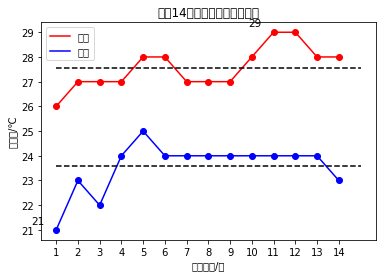

[3.6666666666666665, 0, 0, 0, 3.0, 3.0, 0, 3.75]


/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 39118 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 32423 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:183: RuntimeWarning: Glyph 39118 missing from current font.
  font.set_text(s, 0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:183: RuntimeWarning: Glyph 32423 missing from current font.
  font.set_text(s, 0, flags=flags)


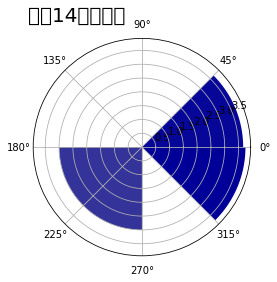

{'多云': 3, '多云转阵雨': 1, '阵雨': 2, '阵雨转雨': 1, '阴': 3, '阴转多云': 1, '多云转晴': 2, '阴转雨': 1}


/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 27668 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 20505 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 20998 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 24067 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 39292 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 22810 missing from current font.
  font.set_

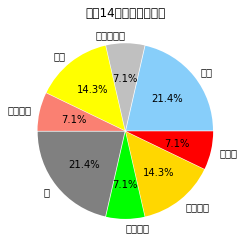

In [65]:
# data14_analysis.py
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import math

def tem_curve(data):
	"""温度曲线绘制"""
	date = list(data['日期'])
	tem_low = list(data['最低气温'])
	tem_high = list(data['最高气温'])
	for i in range(0,14):
		if math.isnan(tem_low[i]) == True:
			tem_low[i] = tem_low[i-1]
		if math.isnan(tem_high[i]) == True:
			tem_high[i] = tem_high[i-1]

	tem_high_ave = sum(tem_high)/14					# 求平均高温 
	tem_low_ave = sum(tem_low)/14					# 求平均低温 
	
	tem_max = max(tem_high)				
	tem_max_date = tem_high.index(tem_max)			# 求最高温度
	tem_min = min(tem_low)
	tem_min_date = tem_low.index(tem_min)			# 求最低温度

	x = range(1,15)
	plt.figure(1)
	plt.plot(x,tem_high,color='red',label='高温')				# 画出高温度曲线
	plt.scatter(x,tem_high,color='red')					# 点出每个时刻的温度点
	plt.plot(x,tem_low,color='blue',label='低温')				# 画出低温度曲线
	plt.scatter(x,tem_low,color='blue')					# 点出每个时刻的温度点
	
	plt.plot([1, 15], [tem_high_ave, tem_high_ave], c='black', linestyle='--') 	# 画出平均温度虚线
	plt.plot([1, 15], [tem_low_ave, tem_low_ave], c='black', linestyle='--') 	# 画出平均温度虚线
	plt.legend()
	plt.text(tem_max_date+0.15, tem_max+0.15, str(tem_max), ha='center', va='bottom', fontsize=10.5)  # 标出最高温度
	plt.text(tem_min_date+0.15, tem_min+0.15, str(tem_min), ha='center', va='bottom', fontsize=10.5)  # 标出最低温度
	plt.xticks(x)
	plt.title('未来14天高温低温变化曲线图')
	plt.xlabel('未来天数/天')
	plt.ylabel('摄氏度/℃')
	plt.show()
def change_wind(wind):
	"""改变风向"""
	for i in range(0,14):
		if wind[i] == "北风":
			wind[i] = 90
		elif wind[i] == "南风":
			wind[i] = 270
		elif wind[i] == "西风":
			wind[i] = 180
		elif wind[i] == "东风":
			wind[i] = 360
		elif wind[i] == "东北风":
			wind[i] = 45
		elif wind[i] == "西北风":
			wind[i] = 135
		elif wind[i] == "西南风":
			wind[i] = 225
		elif wind[i] == "东南风":
			wind[i] = 315
	return wind


def wind_radar(data):
	"""风向雷达图"""
	wind1 = list(data['风向1'])
	wind2 = list(data['风向2'])
	wind_speed = list(data['风级'])
	wind1 = change_wind(wind1)
	wind2 = change_wind(wind2)
	
	degs = np.arange(45,361,45)
	temp = []
	for deg in degs:
		speed = []
		# 获取 wind_deg 在指定范围的风速平均值数据
		for i in range(0,14):
			if wind1[i] == deg:
				speed.append(wind_speed[i])
			if wind2[i] == deg:
				speed.append(wind_speed[i])
		if len(speed) == 0:
			temp.append(0)
		else:
			temp.append(sum(speed)/len(speed))
	print(temp)
	N = 8
	theta = np.arange(0.+np.pi/8,2*np.pi+np.pi/8,2*np.pi/8)
	# 数据极径
	radii = np.array(temp)
	# 绘制极区图坐标系
	plt.axes(polar=True)
	# 定义每个扇区的RGB值（R,G,B），x越大，对应的颜色越接近蓝色
	colors = [(1-x/max(temp), 1-x/max(temp),0.6) for x in radii]
	plt.bar(theta,radii,width=(2*np.pi/N),bottom=0.0,color=colors)
	plt.title('未来14天风级图',x=0.2,fontsize=20)
	plt.show()

def weather_pie(data):
	"""绘制天气饼图"""
	weather = list(data['天气'])
	dic_wea = { }
	for i in range(0,14):
		if weather[i] in dic_wea.keys():
			dic_wea[weather[i]] += 1
		else:
			dic_wea[weather[i]] = 1
	print(dic_wea)
	explode=[0.01]*len(dic_wea.keys())
	color = ['lightskyblue','silver','yellow','salmon','grey','lime','gold','red','green','pink']
	plt.pie(dic_wea.values(),explode=explode,labels=dic_wea.keys(),autopct='%1.1f%%',colors=color)
	plt.title('未来14天气候分布饼图')
	plt.show()

def main():
	plt.rcParams['font.sans-serif']=['SimHei']	# 解决中文显示问题
	plt.rcParams['axes.unicode_minus'] = False  # 解决负号显示问题
	data14 = pd.read_csv('weather14.csv')
	print(data14)
	tem_curve(data14)
	wind_radar(data14)
	weather_pie(data14)

if __name__ == '__main__':
	main()


In [66]:
import matplotlib 
print(matplotlib.matplotlib_fname())


/usr/local/lib/python3.7/dist-packages/matplotlib/mpl-data/matplotlibrc
